In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_45396\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - poletje

In [4]:
summer_mask = accidents['NastanekDatumCas'].dt.month.isin([6, 7, 8])

summer_accidents = accidents[summer_mask]
# print(f"NastanekDatumCas column dtype: {summer_accidents['NastanekDatumCas'].dtype}")

hours = summer_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsSummer",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

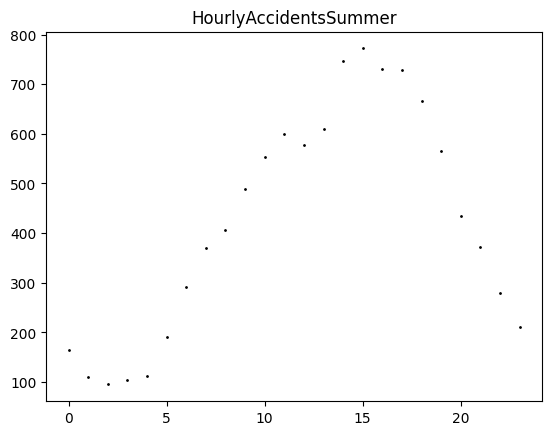

In [5]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsSummer"])

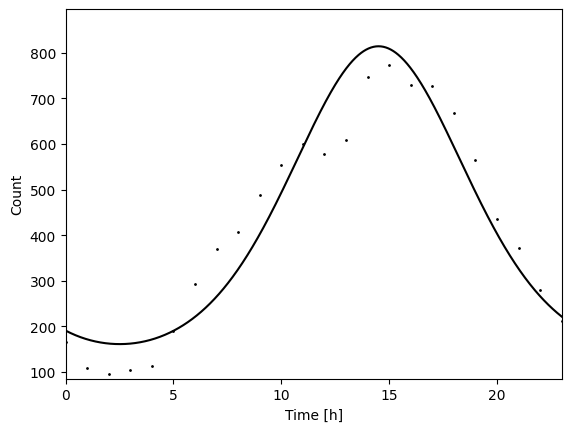

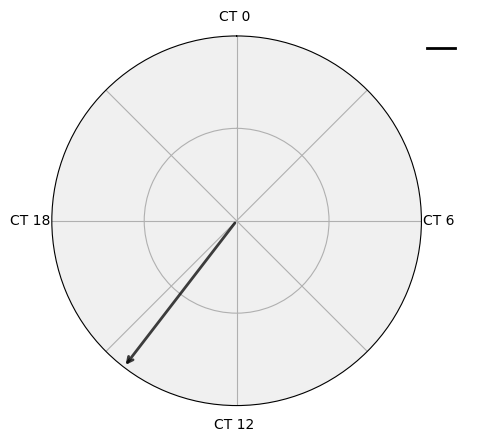

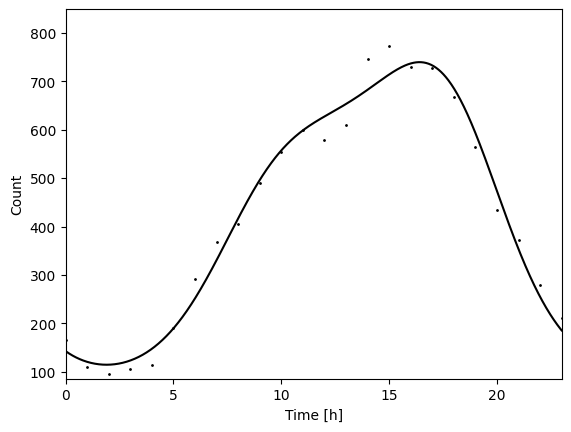

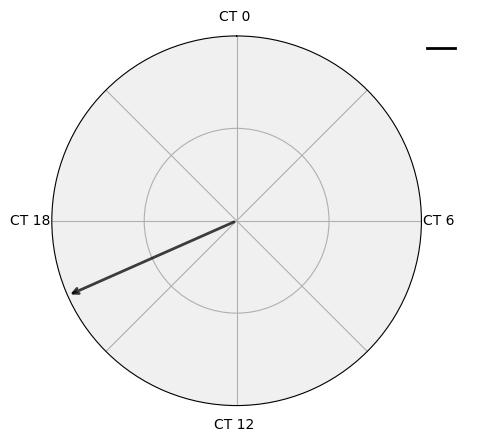

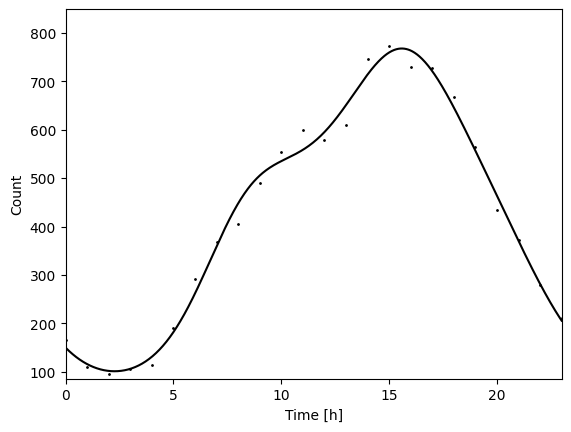

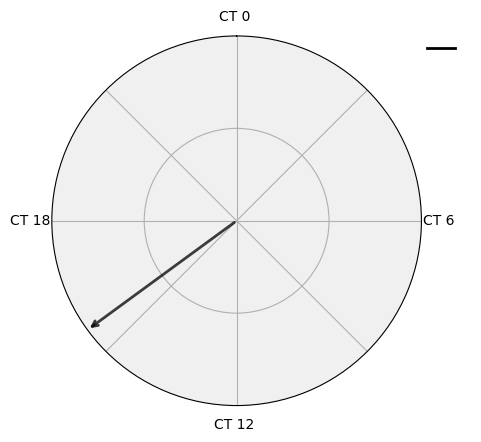

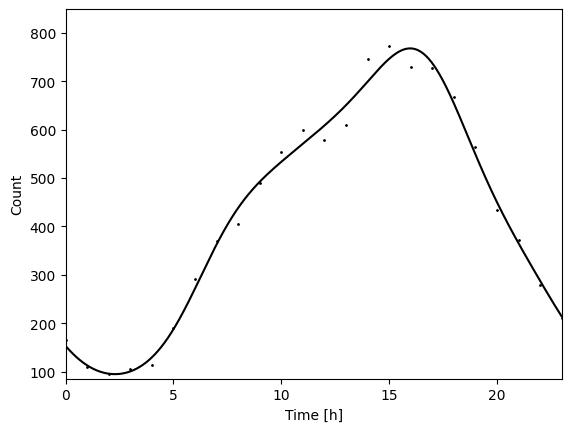

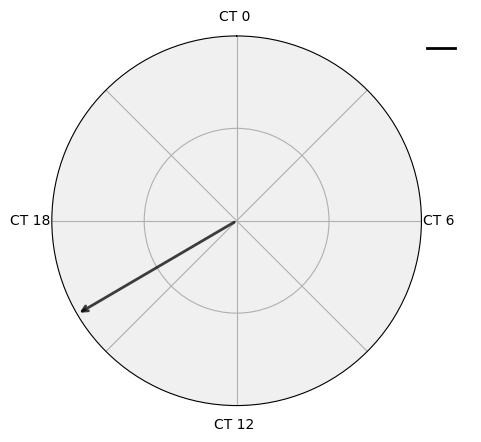

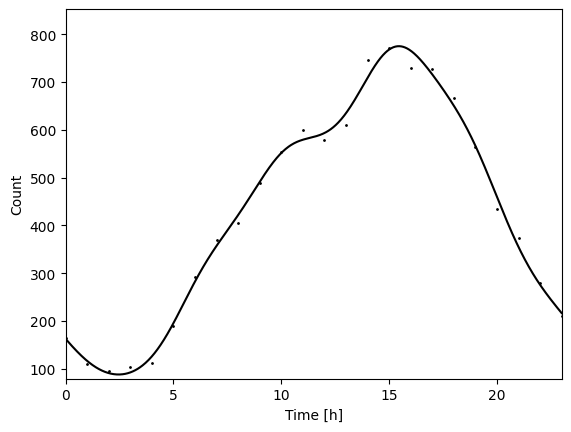

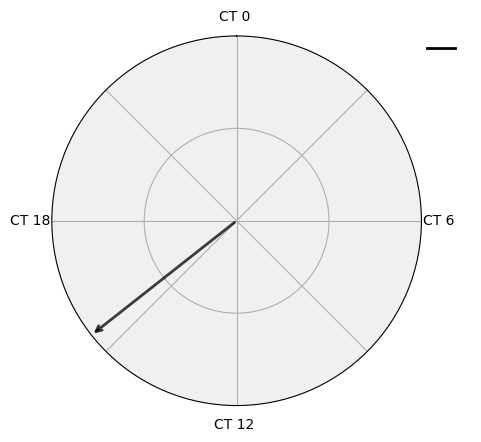

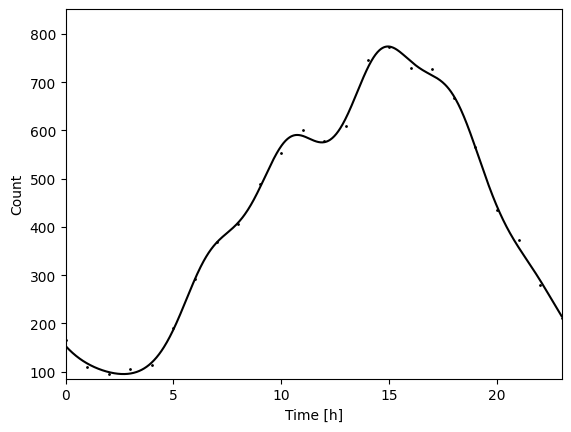

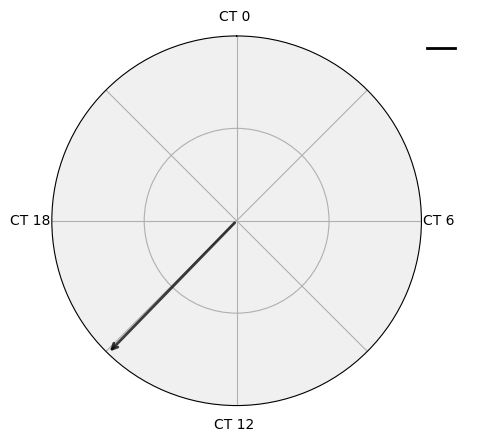

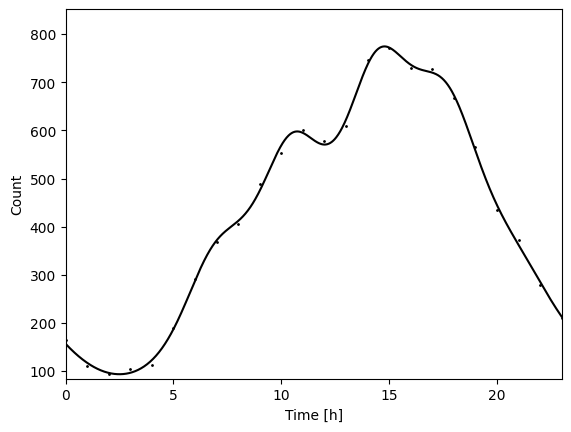

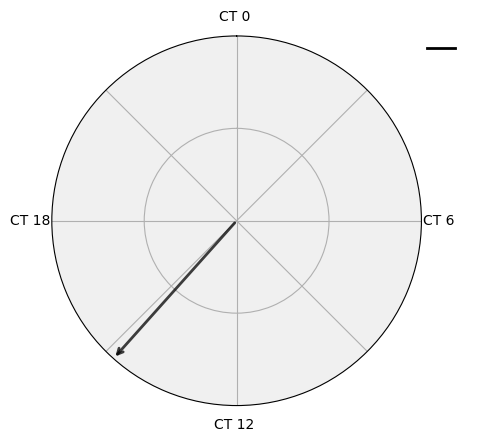

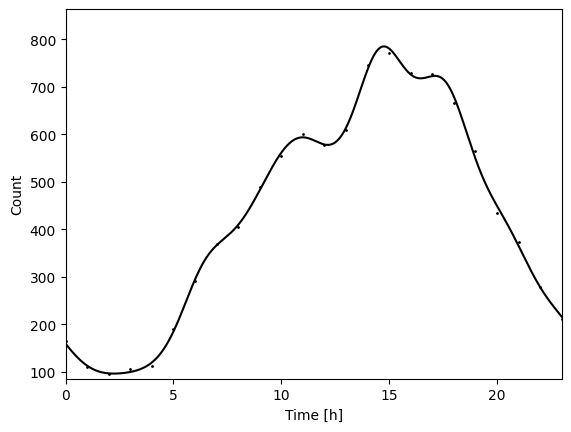

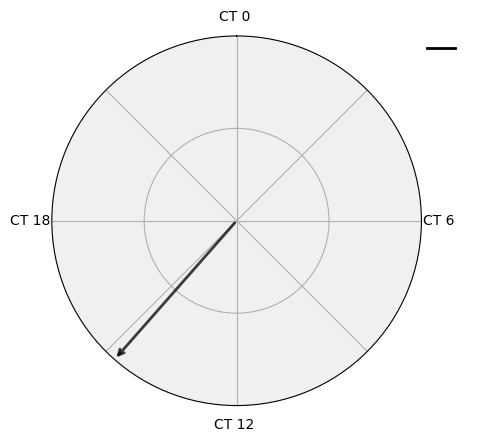

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


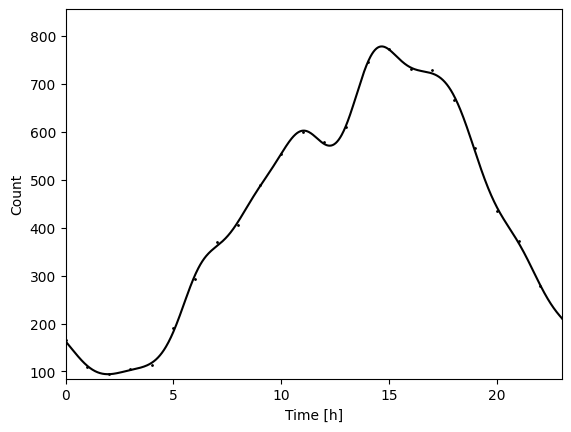

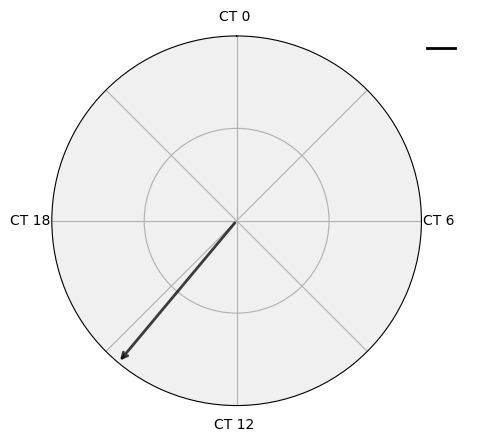

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


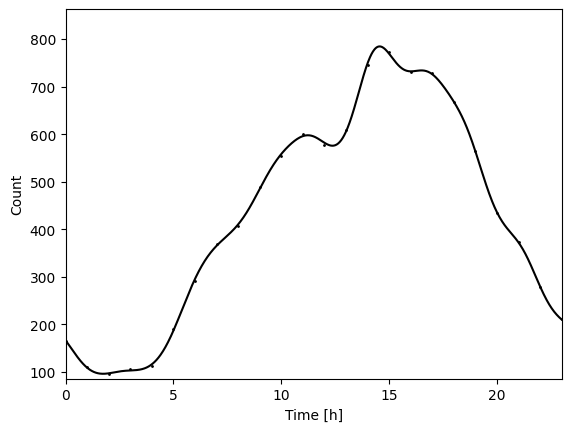

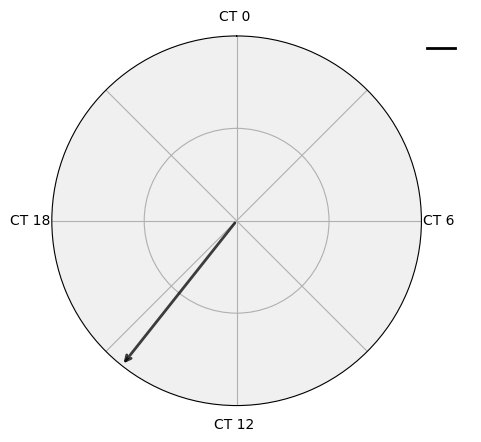

In [18]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsSummer', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsSummer', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsSummer',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [19]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsSummer,24.0,1.0,6.132495e-14,6.132495e-14,107323.341863,-134.803843,0.184127,326.306916,2.485248,487.670782,[14.507050705070508],[813.977666960849],[2.510651065106511],[161.363886510272],277.607685,282.319900
1,HourlyAccidentsSummer,24.0,2.0,9.647840e-21,1.071982e-20,21878.120101,-115.206666,0.302735,312.610201,1.987570,427.029393,[16.40804080408041],[739.6395435282527],[1.8961896189618963],[114.41919255225694],242.413332,249.481655
2,HourlyAccidentsSummer,24.0,3.0,1.926986e-23,2.752837e-23,11562.889411,-105.399752,0.362089,333.439980,2.202477,434.387814,[15.587158715871588],[767.827775801462],[2.265826582658266],[100.9478342286641],226.799504,236.223934
3,HourlyAccidentsSummer,24.0,4.0,4.276269e-23,5.345337e-23,11045.666962,-103.074422,0.376163,336.618848,2.100679,431.423087,[15.975997599759978],[768.0418284728341],[2.285028502850285],[94.80424027763699],226.148843,237.929381
4,HourlyAccidentsSummer,24.0,5.0,4.596516e-24,7.660860e-24,6282.216471,-97.761130,0.408320,343.202924,2.237666,431.615938,[15.452745274527453],[774.818666519115],[2.453045304530453],[88.41301448525843],219.522259,233.658905
5,HourlyAccidentsSummer,24.0,6.0,6.205830e-27,1.551457e-26,2132.012731,-87.861033,0.468239,339.351744,2.370883,434.532080,"[10.738673867386739, 14.943894389438945]","[590.5628630322843, 773.8838238833974]",[2.678667866786679],[95.18038898451027],203.722067,220.214820
6,HourlyAccidentsSummer,24.0,7.0,9.865735e-27,1.973147e-26,1596.366070,-85.582294,0.482030,340.405890,2.412356,433.974962,"[10.738673867386739, 14.785478547854787]","[597.7923950127079, 774.380726034279]",[2.4962496249624966],[93.56908702735657],203.164587,222.013448
7,HourlyAccidentsSummer,24.0,8.0,8.183186e-28,2.727729e-27,1250.995139,-80.195386,0.514633,344.549784,2.419897,440.848397,"[10.993099309930994, 14.756675667566757, 17.12...","[593.9437483987709, 785.3978965460993, 723.371...",[2.2370237023702373],[96.29862395233955],196.390772,217.595741
8,HourlyAccidentsSummer,24.0,9.0,1.075636e-29,5.378180e-29,605.507910,-72.830879,0.559206,341.716847,2.446289,436.034230,"[11.036303630363037, 14.655865586558656]","[602.2031781840464, 777.7510776830044]",[1.9585958595859587],[94.31738275093855],185.661758,209.222835
9,HourlyAccidentsSummer,24.0,10.0,3.924875e-34,3.924875e-33,187.727795,-59.032687,0.642716,344.364257,2.471424,440.263768,"[11.233123312331234, 14.559855985598562, 16.49...","[597.7174329172465, 784.6280051253189, 734.129...",[1.737773777377738],[95.89959328996163],162.065374,187.982558


### Katero je najboljše število komponent

In [20]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSummer,24,3,1.926986e-23,11562.889411,-105.399752,0.362089,226.799504,236.223934,333.43998,2.202477,434.387814,[15.587158715871588],[767.827775801462],[2.265826582658266],[100.9478342286641]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


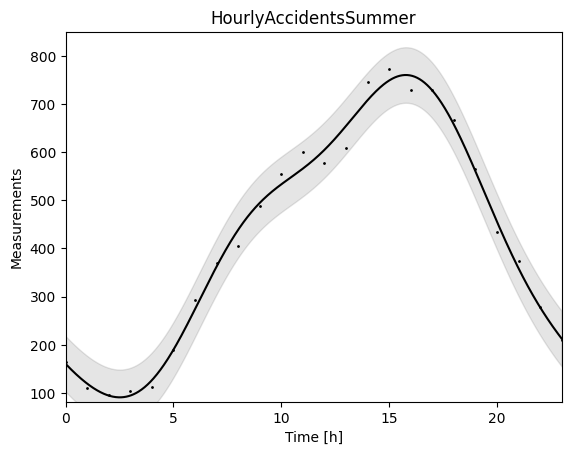

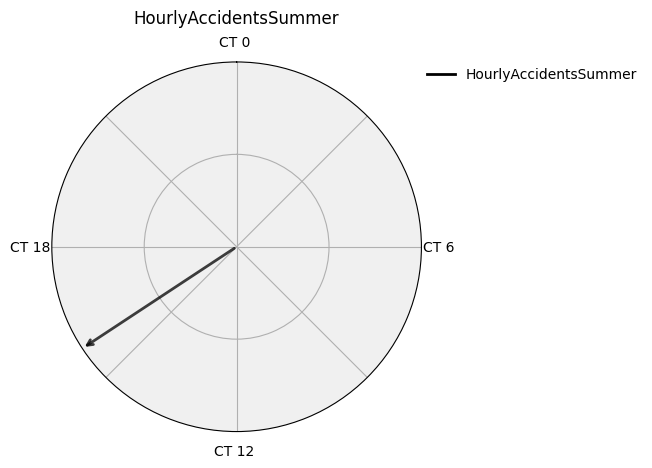

In [21]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsSummer",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

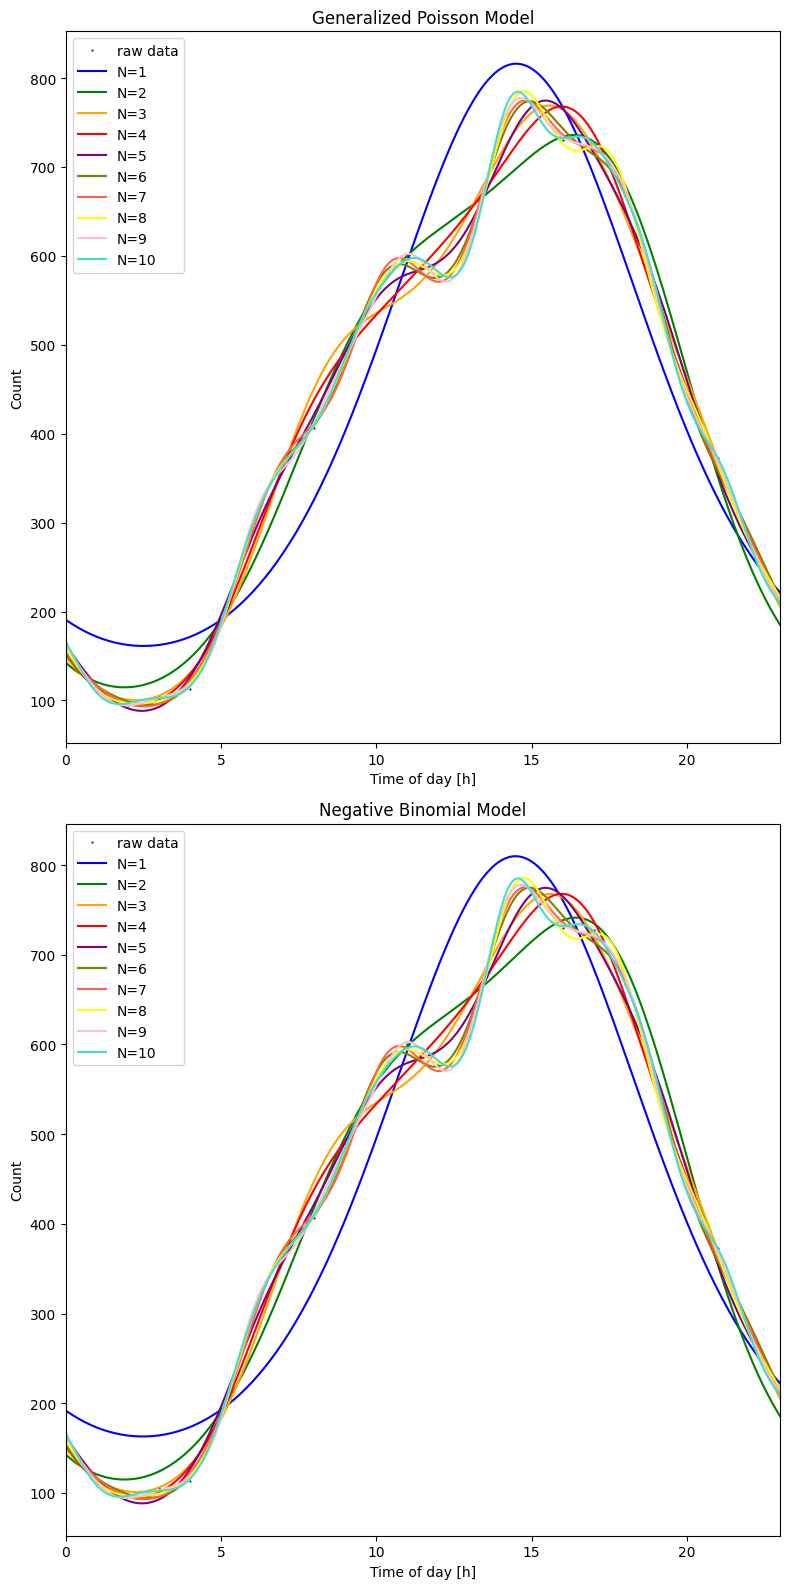

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,327.42,488.72,[14.51],[816.14],6.144719e-14,108136.528766,277.611668,282.323883,-134.805834,"[-4.806121636167745, -5.451046023520917, -5.74...",424.927749,"[190.85229818008395, 171.6419021805019, 162.44...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[190.85229818008395, 188.43698175671798, 186.1..."
1,gen_poisson,2,310.60,425.39,[16.32],[735.99],1.228186e-20,21748.814672,242.905787,249.974110,-115.452893,"[-4.664353083126002, -3.846062176101924, -4.42...",423.582740,"[142.62760100046566, 120.66062237598328, 114.8...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[142.62760100046566, 139.59213189105265, 136.7..."
2,gen_poisson,3,334.43,434.69,[15.62],[769.12],3.325705e-23,11759.089850,227.928229,237.352660,-105.964115,"[-4.346763992411979, -3.314307848770227, -3.31...",424.509838,"[149.2441156230054, 115.0534881187107, 100.899...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[149.2441156230054, 144.8442230169654, 140.667..."
3,gen_poisson,4,336.58,431.41,[16.02],[767.98],4.545239e-23,11046.032930,226.276926,238.057465,-103.138463,"[-3.925707997991964, -3.213347980558595, -3.09...",424.208333,"[153.02291981497834, 112.88861869499367, 95.71...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[153.02291981497834, 147.9652531826444, 143.13..."
4,gen_poisson,5,343.18,431.50,[15.42],[774.68],7.884909e-24,6272.317667,220.668785,234.805431,-98.334392,"[-3.374168775082353, -3.4170890374972913, -3.1...",424.208333,"[163.08011679953626, 116.80513179366783, 91.20...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[163.08011679953626, 157.8845320670972, 152.77..."
5,gen_poisson,6,339.48,434.44,"[10.71, 14.91]","[590.66, 773.92]",1.122422e-24,2130.854743,214.853767,231.346521,-93.426884,"[-3.929903991227036, -3.419505701931996, -3.19...",424.208333,"[152.98499202846588, 116.83808264885177, 98.95...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[152.98499202846588, 148.24979721872228, 143.7..."
6,gen_poisson,7,340.68,433.96,"[10.71, 14.81]","[597.67, 774.63]",7.677061e-24,1591.867454,217.602810,236.451671,-92.801405,"[-3.6403498588665286, -3.4399153720866877, -3....",424.208333,"[156.48562236271425, 117.11074646626155, 96.10...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[156.48562236271425, 151.7740795904866, 147.23..."
7,gen_poisson,8,344.44,440.81,"[11.01, 14.71, 17.12]","[594.11, 785.25, 723.53]",2.892434e-23,1244.318163,219.338656,240.543625,-91.669328,"[-3.5033893717042304, -3.210801648913801, -3.1...",424.208333,"[158.86524681353112, 112.9595215936447, 96.849...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[158.86524681353112, 153.22820678750597, 147.7..."
8,gen_poisson,9,341.63,436.18,"[11.01, 14.61]","[602.36, 777.81]",1.189694e-22,606.053223,221.504725,245.065802,-90.752363,"[-3.3764863524571354, -3.1832060753577593, -3....",424.208333,"[162.921426156454, 111.98763978699672, 94.5500...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[162.921426156454, 157.48118876766836, 151.958..."
9,gen_poisson,10,344.31,440.19,"[11.21, 14.51, 16.52]","[597.66, 784.5, 734.23]",5.186296e-22,187.895288,224.016877,249.934062,-90.008439,"[-3.366783487484696, -3.1691439302149007, -3.1...",424.208333,"[166.0963371772577, 108.5720744066752, 96.8324...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[166.0963371772577, 159.85976402792278, 153.41..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


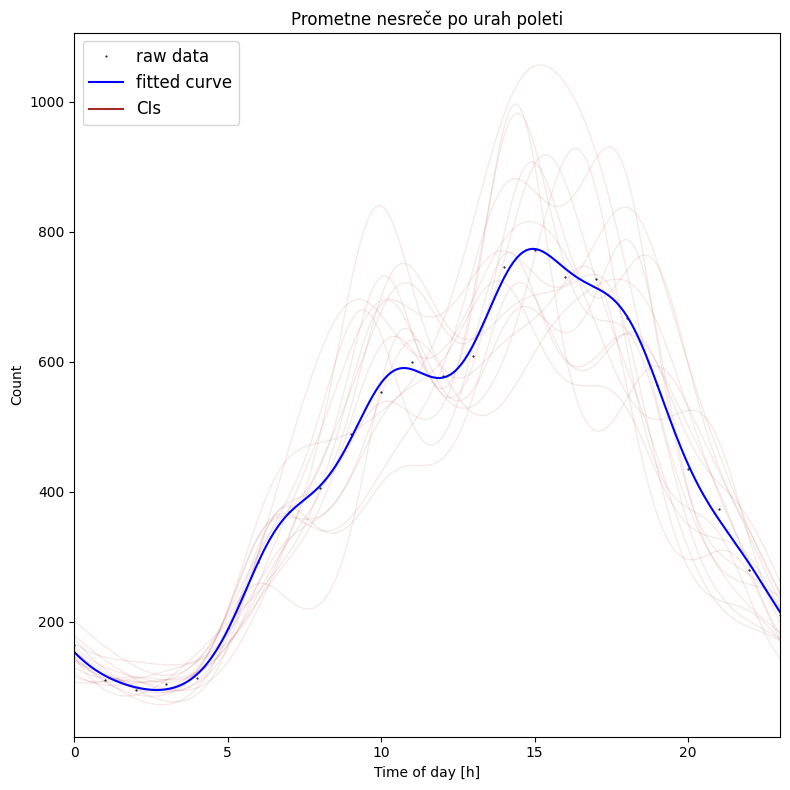

Intervali zaupanja:


,0,1
0,5.783206,5.963308
1,-0.602979,-0.424199
2,-0.895289,-0.594799
3,-0.342062,-0.079357
4,-0.223485,-0.064578
5,-0.181914,0.048682
6,-0.010530,0.144203
7,-0.073306,0.048899
8,-0.064268,0.135842
9,-0.013199,0.071654


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah poleti', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,339.48
mesor,434.44
peaks,"[10.71, 14.91]"
heights,"[590.66, 773.92]"
amplitude_CIs,"[261.83, 451.86]"
mesor_CIs,"[349.67, 542.74]"
peaks_CIs,"[[10.09, 11.72], [14.13, 16.06]]"
heights_CIs,"[[559.35, 649.17], [617.48, 988.61]]"
